# LSTM Autoencoder Model Analysis - California

This notebook uses California Climate Zone pretrained models to predict anomalies on California (no need to retrain models).

This notebook generates plots of the anomaly prediction and saves the plots locally on sagemaker.  

## Synthetic Methane Anomaly Analysis

In [2]:
# #For Synthetic Methane Anomaly (This was used to randomlly test our algorithm)

# from datetime import timedelta, date
# from numpy import random

# #random zone
# rand_zone = random.random_integers(16)
# print("random zone:", rand_zone)

# #random index to change (in the test set, so last 180 days)
# rand_day_180 = int(random.random_integers(180)) 
# print("random index in the last 180 days:", rand_day_180)

# #average and max methane times 1.1% for anomaly
# s3_file_path = 's3://methane-capstone/data/dt=latest/data-zone-combined.parquet.gzip'
# df = pd.read_parquet(s3_file_path)
# factor=1.1
# methane_mean = df[df['BZone']==rand_zone]['methane_mixing_ratio_mean'].mean()
# methane_max = df[df['BZone']==rand_zone]['methane_mixing_ratio_mean'].max()
# print("mean methane * factor: ", methane_mean*factor)
# print("max methane * factor: ", methane_max*factor)

# s3_file_path = 's3://methane-capstone/data/dt=latest/data-zone-combined.parquet.gzip'
# df = pd.read_parquet(s3_file_path)

# df = df[df['BZone']==5]
# df = df.reset_index(drop=True)

# index_to_change = df.shape[0] -  rand_day_180
# print("index to change:", index_to_change)

# print("BEFORE", df[df.index==index_to_change]['methane_mixing_ratio_mean'])

# df.loc[index_to_change, 'methane_mixing_ratio_mean'] = methane_mean*factor

# print("AFTER", df[df.index==index_to_change]['methane_mixing_ratio_mean'])

In [2]:
# s3_file_path = 's3://methane-capstone/data/dt=latest/data-zone-combined.parquet.gzip'
# df = pd.read_parquet(s3_file_path)

In [3]:
import matplotlib.patches as mpatches
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import altair as alt


import os
import glob
import time
import sklearn
import numpy as np
import pandas as pd
import geojson
import json
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
import geopandas as gpd
from shapely.geometry import Point
from descartes import PolygonPatch


from pylab import rcParams
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 10, 8

from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.sequence import TimeseriesGenerator

#Altair puts a limit on plotting only 5000 rows from a pd.DataFrame. This line gets rid of that limit
alt.data_transformers.disable_max_rows()


DataTransformerRegistry.enable('default')

In [135]:
#####################################
# Function to load data, given region
#####################################
def load_all_zone_data(zone, describe=True):
    
    #Read in Data
    s3_file_path = 's3://methane-capstone/data/dt=latest/data-zone-combined.parquet.gzip'
    df = pd.read_parquet(s3_file_path)
    df.drop_duplicates(inplace=True)
    df = df[df['BZone']==zone]
    df = df.reset_index(drop=True)
    
#     # THIS SECTION IS FOR SYNTHETIC DATA, COMMENT OUT IF NOT SYNTHETIC DATA
#     index_to_change = 775
#     methane_mean = df['methane_mixing_ratio_bias_corrected_mean'].mean()
#     factor = 1.025
#     synthetic_methane = methane_mean*factor    
#     df.loc[index_to_change, 'methane_mixing_ratio_bias_corrected_mean'] = synthetic_methane  
#     # EMD SECTION FOR SYNTHETIC DATA, COMMENT OUT IF NOT SYNTHETIC DATA
    
    
    df['time_utc'] = pd.to_datetime(df['time_utc']).dt.date.astype('datetime64[ns]')
    df.set_index(['time_utc'], inplace=True)

    train_date_threshold = '2021-01-01'
    validation_date_threshold = '2021-06-11'

    train = df.loc[df.index < train_date_threshold]
    validation = df.loc[(df.index >= validation_date_threshold)]   #val and test are the same
    test = df.loc[df.index >= validation_date_threshold]           #val and test are the same

    #Print time range
    print("start_dt:", df.index.min(), "\nend_dt:", df.index.max(), "\nnumber_days:", df.index.max() - df.index.min(), "\n")
    print(df.shape, "\n")
    print(df.dtypes, "\n")
    print(train.shape, validation.shape, test.shape)
    
    return df, train, validation, test


####################################################################
# Function to generate trainx, trainy and return number of features 
# Window Function
####################################################################
def generate_datasets(data, window_size, describe=False):
    _l = len(data) 
    Xs = []
    Ys = []
    for i in range(0, (_l - window_size)):
        # because this is an autoencoder - our Ys are the same as our Xs. No need to pull the next sequence of values
        Xs.append(data[i:i+window_size])
        Ys.append(data[i:i+window_size])
        
    Xs=np.array(Xs)
    Ys=np.array(Ys)    
    
    if describe:
        print(Xs.shape, Ys.shape)
    
    return (Xs.shape[2], Xs, Ys)

### Data 
    * Standardize
    * Training
    * Loss Calculation

In [136]:
####################################################################
# Function to standard scaler the data
####################################################################
def standardize_data(train, validation, test, feature_cols, zone, describe=False):

    train_input = train[feature_cols]
    val_input = validation[feature_cols]
    test_input = test[feature_cols]

    import pickle
    standard_scaler_name = f'ScalerModel_Zone{zone}'                              
    scaler = pickle.load(open(f'/root/methane/pipelines/resources/models/autoencoder/{standard_scaler_name}.pkl','rb'))

    train_scaled = scaler.transform(train_input)
    val_scaled = scaler.transform(val_input)
    test_scaled = scaler.transform(test_input)

    train_features = train_scaled
    val_features = val_scaled
    test_features = test_scaled

    if describe:
        print("train:", train_features.shape)
        print("val:", val_features.shape)
        print("test:", test_features.shape)

    return train_scaled, val_scaled, test_scaled, scaler

####################################################################
# Function to calculate loss
####################################################################
def calculate_loss(feature_num, model, dataX):

    #Predict model and calculate MSE of the feature (0th feature = methane)    
    pred = model.predict(dataX)[:, :, feature_num]
    truth = dataX[:, :, feature_num]

    mse_loss = np.mean(np.square(pred -  truth), axis=1)     
    return mse_loss, pred 




### MATPLOTLIB - Plot Functions

In [137]:

####################################################################
# Functions to plot
####################################################################

def plotting_distplot(train_mse_loss, val_mse_loss, feature, describe=False):
    
    #MSE LOSS
#     print("Train MSE loss distribution")
    print("Plots are for feature {}".format(feature))
    sns.distplot(train_mse_loss, bins=50, kde=True)
#     print("Validation MSE loss distribution")
    sns.distplot(val_mse_loss, bins=50, kde=True)
    plt.legend(labels=["TrainMSE","ValMSE"])
    
    if describe:
        print('predicted train shape:', X_train_pred.shape)       
        print('original train methane shape:', trainX_methane.shape)
        print('train_mse_loss shape: ', train_mse_loss.shape)
        print('predicted val shape:', X_val_pred.shape)       
        print('original val methane shape:', valX_methane.shape)
        print('val_mse_loss shape: ', val_mse_loss.shape)


def model_analysis_plots(region, train_mse_loss, ANOMALY_THRESHOLD, val_score_df,
                         validation, val_scaled, val_anomalies, mm_scaler, feature, pretrained_model='', pretrained=False , save=False):
     
    #combined plots
    fig, axs = plt.subplots(3, 1, figsize=(10,15))  #specify how many sub - plots in figure

    plt. subplots_adjust(hspace=0.5)   #spacing between each subplot
    titles_font_size = 12
    ticks_font_size = 8
    fig.suptitle("LSTM AE Trained Model, Feature {}".format(region, feature))  #title for entire subplot
    if pretrained:
#         fig.suptitle("LSTM AE Pretrained Model ({}), Feature {}".format(pretrained_model, feature))  #title for entire subplot
        fig.suptitle("LSTM AE Pretrained Model ({})".format(pretrained_model))  #title for entire subplot
    
    #Training Losses
    plt.setp(axs[0].get_xticklabels(), fontsize=ticks_font_size, rotation=25)#, horizontalalignment="left")
    plt.setp(axs[0].get_yticklabels(), fontsize=ticks_font_size)#,  horizontalalignment="left")
    axs[0].hist(train_mse_loss, bins=50, label='MSE Frequency')
    axs[0].axvline(ANOMALY_THRESHOLD, color = 'orange', label= 'threshold')
    axs[0].set_title("Histogram of Training Losses", fontsize=titles_font_size)
    axs[0].set_xlabel("Mean Squared Error", fontsize = titles_font_size) 
    axs[0].set_ylabel("Frequency", fontsize = titles_font_size) 
    axs[0].legend(fontsize=titles_font_size)


    #Validation Errors
    plt.setp(axs[1].get_xticklabels(), fontsize=ticks_font_size, rotation=25)#, horizontalalignment="left")
    plt.setp(axs[1].get_yticklabels(), fontsize=ticks_font_size)#,  horizontalalignment="left")
    axs[1].plot(val_score_df.index, val_score_df.loss, label = 'loss')
    axs[1].plot(val_score_df.index, val_score_df.threshold, label = 'threshold')
    axs[1].set_title("Validation Loss vs. Anomaly Loss Threshold", fontsize=titles_font_size)
    axs[1].legend(fontsize=10)
    axs[1].set_ylabel("Frequency", fontsize = titles_font_size) 

    #Validation Methane
    feature_num = feature_number_map[feature]
    plt.setp(axs[2].get_xticklabels(), fontsize=ticks_font_size, rotation=25)#, horizontalalignment="left")
    plt.setp(axs[2].get_yticklabels(), fontsize=ticks_font_size)#,  horizontalalignment="left")
    axs[2].set_title("Validation Methane", fontsize=titles_font_size)
    axs[2].plot(validation[window_length:].index,  mm_scaler.inverse_transform(val_scaled[window_length:])[:,feature_num],  label = feature )
    axs[2].scatter(
        val_anomalies.index,
        val_anomalies[feature],
        color = sns.color_palette()[3],
        s=10,
        label='anomaly')
    axs[2].legend(fontsize=titles_font_size)

    if save:
        feature_num = feature_number_map[feature]
        fig.savefig("./resources/figures/california/lstmae_pretrained_on_{}".format(pretrained_model))
    
#     fig.clear(True)
    
####################################################################
# Functions for Anomaly Detection
####################################################################

def anomaly(train_mse_loss, other_mse_loss, train, other_data):

    upper,lower = np.percentile(train_mse_loss,[75,25])
    ANOMALY_THRESHOLD = 5*(upper-lower)

    other_score_df = pd.DataFrame(index=other_data[window_length:].index)
    other_score_df['loss'] = other_mse_loss
    other_score_df['threshold'] = ANOMALY_THRESHOLD
    other_score_df['anomaly'] = other_score_df.loss > other_score_df.threshold
    
    ## THIS IS WHERE WE CAN DETERMINE THE BUCKETING ## 
    
    for feature in feature_cols:
        other_score_df[feature] = other_data[window_length:][feature]
        
    other_anomalies = other_score_df[other_score_df.anomaly]
    
    return other_score_df, other_anomalies, ANOMALY_THRESHOLD

### Load Data

In [143]:
zone = 11   #Define Zone
df, train, val, test = load_all_zone_data(zone) 

start_dt: 2018-11-30 00:00:00 
end_dt: 2021-10-17 00:00:00 
number_days: 1052 days 00:00:00 

(863, 22) 

BZone                                                                                              int64
reading_count                                                                                      int64
methane_mixing_ratio_mean                                                                        float32
lat_mean                                                                                         float32
methane_mixing_ratio_precision_mean                                                              float32
methane_mixing_ratio_bias_corrected_mean                                                         float32
air_pressure_at_mean_sea_level_mean                                                              float32
air_temperature_at_2_metres_mean                                                                 float32
air_temperature_at_2_metres_1hour_Maximum_mean        

### Track Everything

In [144]:
# # Load pretrained LSTMAE model and Standard Scaler to local sage maker
# import subprocess
# subprocess.check_output(['aws','s3','cp', '--recursive', 's3://methane-capstone/models/autoencoder/dt=latest/pretrained/' ,'/root/methane/models/autoencoder/' ])


Zone # 11
Standard scaler'ing data
Generating Datasets
loading modeling
Loss:  methane_mixing_ratio_bias_corrected_mean 0
Loss:  reading_count 1
Loss:  air_pressure_at_mean_sea_level_mean 2
Loss:  eastward_wind_at_100_metres_mean 3
Loss:  northward_wind_at_100_metres_mean 4
Loss:  air_temperature_at_2_metres_mean 5
Loss:  surface_air_pressure_mean 6
Loss:  integral_wrt_time_of_surface_direct_downwelling_shortwave_flux_in_air_1hour_Accumulation_mean 7
Loss:  precipitation_amount_1hour_Accumulation_mean 8
Loss:  dew_point_temperature_at_2_metres_mean 9



TIME: 4.62 secs


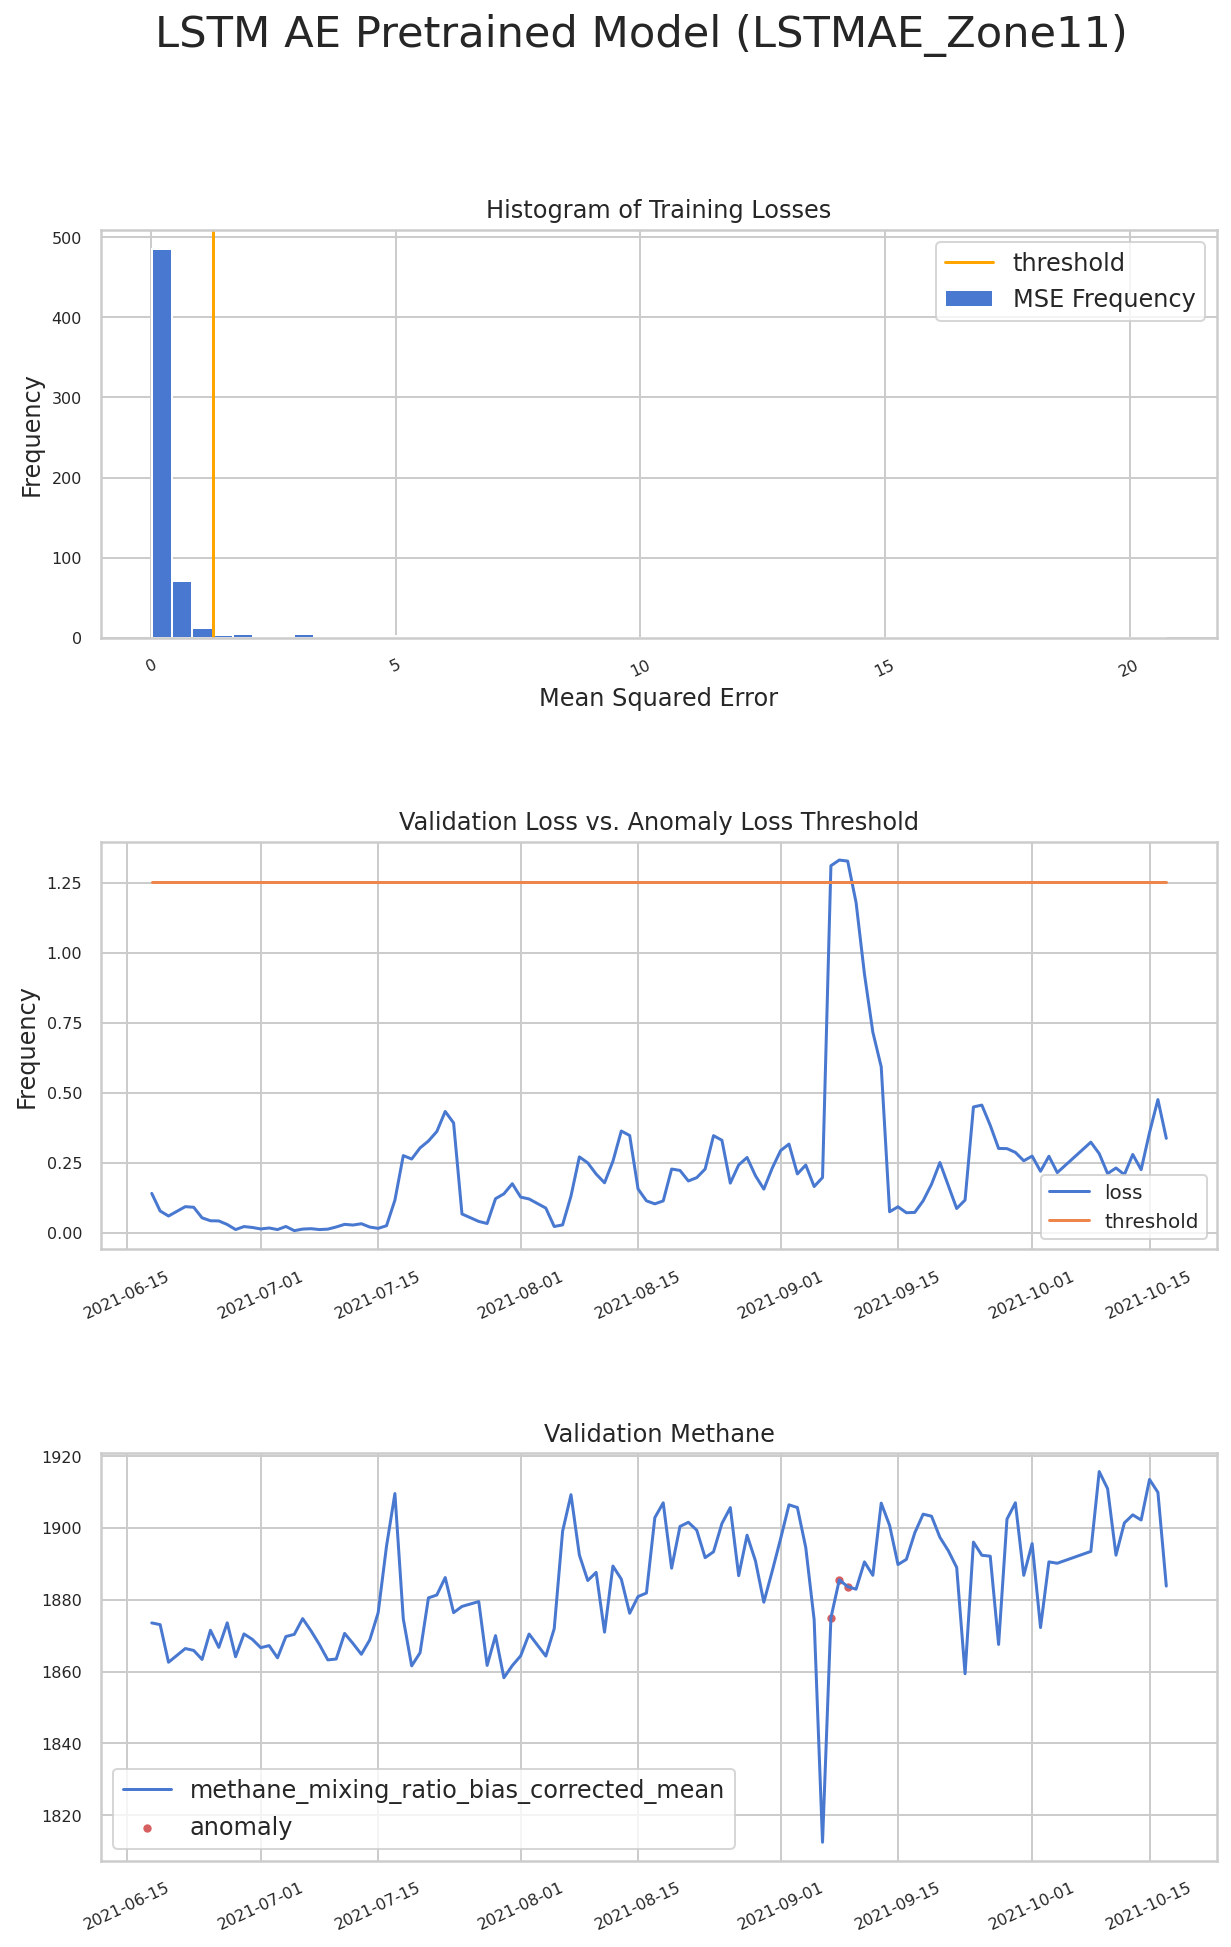

In [146]:
#select region and features
zones = [zone]  #Zone is already selected previously

# Track predictions and losses for analysis across different features
feature_loss_tracker = {key: {'train':{}, 'val':{}, 'test':{}} for key in zones}

#Track all the data frames, raw and scaled
df_tracker = {}

#Track all the metrics from each model training cycle
model_metrics_tracker = {}

drop = False
pretrained=True
model_names = [f'LSTMAE_Zone{zone}']

#make local directory to store results
local_path = '/root/methane/pipelines/resources/models/autoencoder/john/figures/california/'
try:
    os.makedirs(local_path)
except:
    print("")
    
#parameters:          
feature_cols = ['methane_mixing_ratio_bias_corrected_mean',  'reading_count',
                 'air_pressure_at_mean_sea_level_mean',
                 'eastward_wind_at_100_metres_mean',
                 'northward_wind_at_100_metres_mean',
                 'air_temperature_at_2_metres_mean',
                 'surface_air_pressure_mean',
                 'integral_wrt_time_of_surface_direct_downwelling_shortwave_flux_in_air_1hour_Accumulation_mean',
                 'precipitation_amount_1hour_Accumulation_mean' ,
                 'dew_point_temperature_at_2_metres_mean']

for model_name in model_names:

    feature_number_map = {}
    for ind, feature in enumerate(feature_cols, 0):
        feature_number_map[feature] = ind

    start=time.time()

    for zone in zones:

        print("Zone #", zone)
        train_zone = train[train['BZone'] == zone]
        val_zone = val[val['BZone'] == zone]
        test_zone = test[test['BZone'] == zone] 

        if drop:
            #NEED TO DROP ROWS WITH NA VALUES or do interpolate then drop na
            train_zone=train_zone.dropna()
            val_zone=val_zone.dropna()
            test_zone=test_zone.dropna()

        else:

            train_zone=train_zone.interpolate(method='time')   #time method accounts for uneven dates (in case there is missing data for a whole date)
            val_zone=val_zone.interpolate(method='time')
            test_zone=test_zone.interpolate(method='time')
            train_zone=train_zone.dropna()
            val_zone=val_zone.dropna()
            test_zone=test_zone.dropna()
            
        window_length = 7
        batch_size = 32
        num_features = len(feature_cols)
        epochs = 50

        print("Standard scaler'ing data")
        #standardize data
        train_scaled, val_scaled, test_scaled, scaler = standardize_data(train_zone, val_zone, test_zone, feature_cols, zone)


        #Track all data for use later on
        df_tracker[zone] = {'train_zone': train_zone,
                            'val_zone': val_zone,
                            'test_zone': test_zone,
                            'train_scaled': train_scaled,
                            'val_scaled': val_scaled,
                            'test_scaled': test_scaled,
                            'scaler': scaler
                           }

        print("Generating Datasets")
        #generate trainX and trainY
        num_feats_train, trainX, trainY = generate_datasets(train_scaled, window_length)
        num_feats_val, valX, valY = generate_datasets(val_scaled, window_length)
        num_feats_test, testX, testY = generate_datasets(test_scaled, window_length)

        assert num_feats_train == num_feats_test == num_feats_val

        #use pretrained models
        if pretrained == True:
            print("loading modeling")
            #Load model
            model = tf.keras.models.load_model(f'/root/methane/models/autoencoder/{model_name}.h5', compile=False)


        for feature in feature_cols:

            #Predict MSE's:
            feature_num = feature_number_map[feature]
            print("Loss: ", feature, feature_num)

            train_mse_loss, X_train_pred = calculate_loss(feature_num, model, trainX)
            val_mse_loss, X_val_pred = calculate_loss(feature_num, model, valX)
            test_mse_loss, X_test_pred = calculate_loss(feature_num, model, testX)

            feature_loss_tracker[zone]['train'].update({feature: {'train_mse_loss': train_mse_loss, 'X_train_pred':X_train_pred }})
            feature_loss_tracker[zone]['val'].update({feature: {'val_mse_loss': val_mse_loss, 'X_val_pred': X_val_pred }})
            feature_loss_tracker[zone]['test'].update({feature: {'test_mse_loss': test_mse_loss, 'X_test_pred':X_test_pred }})

        print()
        print()
        print()

    end=time.time()
    print("TIME: {time:.2f} secs".format(time=(end-start)))


    # LOOK AT ANOMALIES
    feature = 'methane_mixing_ratio_bias_corrected_mean'
    train_mse_loss = feature_loss_tracker[zones[0]]['train'][feature]['train_mse_loss']
    val_mse_loss = feature_loss_tracker[zones[0]]['val'][feature]['val_mse_loss']
    val_score_df, val_anomalies, ANOMALY_THRESHOLD = anomaly(train_mse_loss, val_mse_loss, train_zone, val_zone)
    
    ### Plot Analysis Plots
    model_analysis_plots(zone, 
                         train_mse_loss,
                         ANOMALY_THRESHOLD,
                         val_score_df, 
                         val_zone,
                         val_scaled, 
                         val_anomalies,
                         scaler,
                         feature, 
                         pretrained_model=model_name, 
                         pretrained=True,
                         save=True)